### Name: Chloe Wohlgemuth
COSC247
Perceptrons

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.stats as st

## Classification - Brown dwarfs (> 13 M_Jup) vs Super & Sub Earths (< 10 M_Earth or <0.0314635457 M_Jup )

* A **brown dwarf** is a type of substellar object that has a mass between those of the heaviest gas giant planets and the least massive stars, i.e. about 13 to 75–80 times that of Jupiter (M_J)
* A **sub-Earth** is a planet less massive than Earth
* A **super earth** has an upper bound of 10 Earth masses

### Data
Data produced by the NASA Exoplanet Archive  http://exoplanetarchive.ipac.caltech.edu
* Confirmed planets --> https://exoplanetarchive.ipac.caltech.edu/cgi-bin/TblView/nph-tblView?app=ExoTbls&config=planets
* Downloaded the table as a CSV file --> My file name: planets_2020.09.03_20.35.38.csv
* BUT, for ease of filename usage, I renamed to: planets090320.csv

In [8]:
# these set the pandas defaults so that it will print ALL values, even for very long lists and large dataframes
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

For a more manageable and plottable dataset, we truncate it to include only things that are legitimately classified as planets (masses < 13 Jupiter masses) within the explicit planet categories.

In [10]:
#read in the data, skipping the first 73 rows of ancillary information
data=pd.read_csv('planets090320.csv', skiprows=76)

#this truncates to only planet detection methods with >30 successful detections (skip if you want all of them)
methods,methods_inds,methods_counts = np.unique(data['pl_discmethod'],return_index=True,return_counts=True)
methods = methods[methods_counts> 30]
print("I am keeping only the following discovery methods: ", methods)

#find the indices of all entries where pl_discmethod is one of these four
inds = [j for j in range(len(data)) if data['pl_bmassj'][j] > 13 or data['pl_bmassj'][j] < 0.0314657534]

#write a new dataframe with just these entries
planets = data.iloc[inds,[6,22]].values #orbital period, mass
planets = planets[planets[:,1].argsort()] # sort based one second column (mass)
planets = np.array(pd.DataFrame(planets).dropna())
planets = np.concatenate([planets[:289], planets[290:]])
types = pd.DataFrame(['super-jupiter' if planets[i][1]>13 else 'super-earth' for i in range(len(planets))])

# print(types[0][284])
# print(types[0][285])

I am keeping only the following discovery methods:  ['Imaging' 'Microlensing' 'Radial Velocity' 'Transit']


(330, 2)


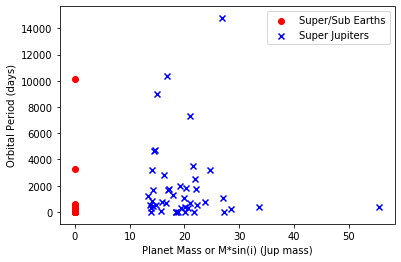

In [11]:
x = planets
y = types.loc[0:len(x)].values
y = np.where(y == 'super-jupiter', -1, 1)
y = [item for items in y for item in items] # flatten list
# plot data
plt.scatter(x=x[:285, 1], y=x[:285, 0],
            color='red', marker='o', label='Super/Sub Earths')
plt.scatter(x=x[285:len(x), 1], y=x[285:len(x), 0],
            color='blue', marker='x', label='Super Jupiters')

plt.xlabel('Planet Mass or M*sin(i) (Jup mass)')
plt.ylabel('Orbital Period (days)')
plt.legend(loc='upper right')

print(planets.shape)
# plt.savefig('images/02_06.png', dpi=300)
plt.show()

### Training the Perceptron Model

In [6]:
import numpy as np


class Perceptron(object):
    """Perceptron classifier.

    Parameters
    ------------
    eta : float
      Learning rate (between 0.0 and 1.0)
    n_iter : int
      Passes over the training dataset.
    random_state : int
      Random number generator seed for random weight
      initialization.

    Attributes
    -----------
    w_ : 1d-array
      Weights after fitting.
    errors_ : list
      Number of misclassifications (updates) in each epoch.

    """
    def __init__(self, eta=0.01, n_iter=50, random_state=1):
        self.eta = eta
        self.n_iter = n_iter
        self.random_state = random_state

    def fit(self, X, y):
        """Fit training data.

        Parameters
        ----------
        X : {array-like}, shape = [n_examples, n_features]
          Training vectors, where n_examples is the number of examples and
          n_features is the number of features.
        y : array-like, shape = [n_examples]
          Target values.

        Returns
        -------
        self : object

        """        
        rgen = np.random.RandomState(self.random_state)
        self.w_ = rgen.normal(loc=0.0, scale=0.01, size=1 + X.shape[1])
        self.errors_ = []

        for _ in range(self.n_iter):
            errors = 0
            for xi, target in zip(X, y):
                update = self.eta * (target - self.predict(xi))
                self.w_[1:] += update * xi
                self.w_[0] += update
                errors += int(update != 0.0)
            self.errors_.append(errors)
        return self

    def net_input(self, X):
        """Calculate net input"""
        return np.dot(X, self.w_[1:]) + self.w_[0]

    def predict(self, X):
        """Return class label after unit step"""
        return np.where(self.net_input(X) >= 0.0, 1, -1)

### Plotting the Planet Data

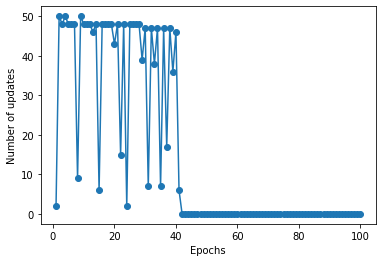

In [7]:
ppn = Perceptron(eta=0.1, n_iter=100)

ppn.fit(x, y)

plt.plot(range(1, len(ppn.errors_) + 1), ppn.errors_, marker='o')
plt.xlabel('Epochs')
plt.ylabel('Number of updates')

# plt.savefig('images/02_07.png', dpi=300)
plt.show()

### Plotting Decision Regions

In [8]:
from matplotlib.colors import ListedColormap


def plot_decision_regions(X, y, classifier, resolution=0.2):

    # setup marker generator and color map
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    # plot class examples
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], 
                    y=X[y == cl, 1],
                    alpha=0.8, 
                    c=colors[idx],
                    marker=markers[idx], 
                    label=cl, 
                    edgecolor='black')

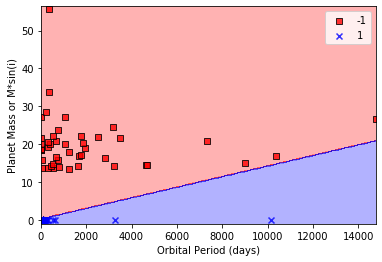

In [9]:
plot_decision_regions(x, y, classifier=ppn)
plt.xlabel('Orbital Period (days)')
plt.ylabel('Planet Mass or M*sin(i)')
plt.legend(loc='upper right')

plt.show()